<h1>Audio-based Keylogger</h1>

<p>Aviad shalom Tzemah</p>
<p>Yuval Siman-TovLevy</p>

# Code setup

## Installations

Python speech features for training the acustic keylogger

In [ ]:
!pip install python_speech_features

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=3729894d687d9af9cd2b4a23dc7f0a7b5ddeafce4e2e237ccdea42da5d9ccaab
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


SymSpell for correcting the predictions

In [ ]:
!python -m pip install -U symspellpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.6 MB 5.2 MB/s 
     |████████████████████████████████| 125 kB 56.2 MB/s 


Pre-made dicrionary of english word frequencies of 82,765 words

In [ ]:
!curl -LJO https://raw.githubusercontent.com/mammothb/symspellpy/master/symspellpy/frequency_dictionary_en_82_765.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1301k  100 1301k    0     0  3585k      0 --:--:-- --:--:-- --:--:-- 3575k


Pre-made dicrionary of english bi-gram words frequencies of 243,342 bi-grams

In [ ]:
!curl -LJO https://raw.githubusercontent.com/mammothb/symspellpy/master/symspellpy/frequency_bigramdictionary_en_243_342.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5016k  100 5016k    0     0   9.7M      0 --:--:-- --:--:-- --:--:--  9.7M


## Imports

In [ ]:
# for the train and test data
from google.colab import drive
drive.mount('/content/gdrive')

# various utilities
import os
import pickle
import matplotlib.pyplot as plt

# for the reconstruction attack
import itertools
import re
from textblob import TextBlob, Word
import numpy as np
from collections import Counter
from symspellpy import SymSpell, Verbosity
import pkg_resources

# Experiments and Results

### Eval method

The following method takes as an arguments: a path to a trained model and path to the test folder and prints a graph of accuracy as the number of guesses of the model (top n guesses)

In [ ]:
def eval_model(model_path, test_path):
  total_num_of_tests = 0
  avg_acc_at_n = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0}
  for root, _, files in os.walk(test_path):
      for file_wav in files:
          if file_wav.endswith(".wav"):  # looking for wavs
            for file_txt in files:
                if file_txt.endswith(f"{file_wav.split('.')[0]}.txt"):  # looking for its ground truth
                    total_num_of_tests += 1
                    # predicting
                    os.system(f"python '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Implementations/Skype-Type-python3/main.py' --opmode 'from_file' --target {os.path.join(root, file_wav)} --pipeline {model_path}")
                    with open('./current_output.pkl', 'rb') as f:
                      predictions = pickle.load(f)  # getting the predictions

                    with open(os.path.join(root, file_txt), "r") as f:
                      ground_truth = [line.strip() for line in f]

                    # calculating the average acc at each top-n, n=1,...,10
                    current_acc = 0
                    total_num_of_chars = len(ground_truth)
                    for n in range(1, 11):
                      for idx, char in enumerate(ground_truth):
                        if idx < len(predictions):
                          if char in predictions[idx][1][:n]: # getting the top n prediction for the ground truth at place idx
                            current_acc += 1
                      current_acc /= total_num_of_chars
                      avg_acc_at_n[n] += (current_acc - avg_acc_at_n[n]) / total_num_of_tests # adding to average
                      current_acc = 0

  print(avg_acc_at_n)  # printing the dots

  # plotting
  x = []
  y = []
  for key, value in iter(avg_acc_at_n.items()):
    x.append(key)
    y.append(value)

  # naming the x axis
  plt.xlabel('Number of guesses')
  # naming the y axis
  plt.ylabel('Accuracy')
  plt.ylim(ymin=0, ymax=1.1)

  # leg = plt.legend()
  # leg_lines = leg.get_lines()
  # plt.setp(leg_lines, linewidth=4)

  plt.plot(x, y, color='red', marker='o')
  plt.show()




### Laptop attack

For the laptop keyboard, we'll be using the keyboard of the laptop, an Asus rog strix vs502-gl laptop with the microphone that comes with the laptop.

#### A-Z train set

First, we'll train a model where its train set are recordings of the entire English aplhabet from A-Z and a space at the end 10 times (for a total of 270 samples evenly distributed)

##### Train

In [ ]:
!python '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Implementations/Skype-Type-python3/generate_model.py' '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Recordings/skype-and-type-recordings/train/laptop-letters' './model_laptop_letters'

##### Tests

First we'll see how the model predicts some sample tests to get the hang of how the implementation works, and then we'll evaluate the accuracy of the model over all of the available tests.

1) should predict the following text: "fourty_two".



In [ ]:
!python '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Implementations/Skype-Type-python3/main.py' --opmode 'from_file' --target '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Recordings/skype-and-type-recordings/test/laptop/fourty_two.wav' --pipeline '/content/model_laptop_letters'

2) should predict the following text: "hello_there".



In [ ]:
!python '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Implementations/Skype-Type-python3/main.py' --opmode 'from_file' --target '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Recordings/skype-and-type-recordings/test/laptop/hello_there.wav' --pipeline '/content/model_laptop_letters'

3) should predict the following text: "did_you_ever_hear_the_tragedy".


In [ ]:
!python '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Implementations/Skype-Type-python3/main.py' --opmode 'from_file' --target '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Recordings/skype-and-type-recordings/test/laptop/tragedy.wav' --pipeline '/content/model_laptop_letters'

We can see that the model outputs for each keystroke it detects a list of predictions, where the first prediction is one he is most sure about and the last one is the one he is least sure about. It is possible to change the amount of predicitons the model returns for each keystroke, but we'll stick to 10.

Now we'll do 4 different tests for this model:

<h3>Same room recordings</h3>

1) Model average accuracy as a function of the number of guesses (top-n guesses) on recordings of random letters:

In [ ]:
eval_model('/content/model_laptop_letters', '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Recordings/skype-and-type-recordings/test/laptop/random-letters/same-room')

2) Model average accuracy as a function of the number of guesses (top-n guesses) on recordings of sentences:

In [ ]:
eval_model('/content/model_laptop_letters', '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Recordings/skype-and-type-recordings/test/laptop/sentences/same-room')

As we can see, the base model perform quite well on both cases. Even though they start quite low they get pretty high toward the end with 0.25 and 0.42 average accuracy at top-1 guesses, 0.69 and 0.75 average accuracy at top-5 guesses and 0.85 and 0.88 average accuracy at top-10 guesses respectively.

<h3> Different room recordings </h3>

3) Model average accuracy as a function of the number of guesses (top-n guesses) on recordings of random letters:

In [ ]:
eval_model('/content/model_laptop_letters', '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Recordings/skype-and-type-recordings/test/laptop/random-letters/different-room')

4) Model average accuracy as a function of the number of guesses (top-n guesses) on recordings of sentences:

In [ ]:
eval_model('/content/model_laptop_letters', '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Recordings/skype-and-type-recordings/test/laptop/sentences/different-room')

Now that we moved to a different setting for the attack (recorded the keystrokes in a different room than the one the train was recorded in) we see a bit of decline in the average accuracy especially in the random letters test. This can be explained by the fact that the two settings had different acoustics and as a result, the model made more mistakes. Although it might be noted that results are still quite high with 0.34 and 0.39 average accuracy at top-1 guesses, 0.63 and 0.72 average accuracy at top-5 guesses and 0.85 and 0.84 average accuracy at top-10 guesses respectively.

#### Realistic train set

Since in a real world attack, the attacker would most likely train on real world texts, the frequency of each letter in his train set won't be the same. The frequency of the letters in the English alphabet can be see in the following chart:

Image taken from  https://www3.nd.edu/~busiforc/handouts/cryptography/letterfrequencies.html


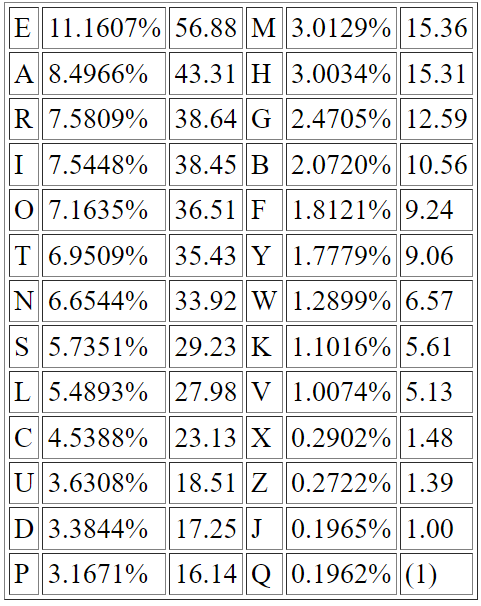

For each letter, we can see its precentage usage in the language, and next to it how many times it would appear when we take the least freqent letter, Q, as a base line (1).

we'll mormalize it so 0-5 times is equal to 1 sample, 5-10 times is equal to 2 samples and so on up to 45-50 times (E will be included here) is equal to 10 samples. And since the mean word length in English is around 5, for every 5 samples we'll add a sample of space (https://www.wolframalpha.com/input/?i=average+english+word+length).

##### Train

In [ ]:
!python '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Implementations/Skype-Type-python3/generate_model.py' '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Recordings/skype-and-type-recordings/train/laptop-real-frequency' './model_laptop_real_frequency'

##### Tests

We'll do the same 4 tests we did to the previous model:

<h3>Same room recordings</h3>

1) Model average accuracy as a function of the number of guesses (top-n guesses) on recordings of random letters:

In [ ]:
eval_model('/content/model_laptop_real_frequency', '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Recordings/skype-and-type-recordings/test/laptop/random-letters/same-room')

2) Model average accuracy as a function of the number of guesses (top-n guesses) on recordings of sentences:

In [ ]:
eval_model('/content/model_laptop_real_frequency', '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Recordings/skype-and-type-recordings/test/laptop/sentences/same-room')

We expected this model to have lower average accuracy than its A-Z model counterpart. But it can be seen the even though that this model has less samples it still had good results and even perfoms better in the case of the recordings of the sentences with 0.6 average accuracy at top-1 guesses, 0.85 average accuracy at top-5 guesses and 0.93 average accuracy at top-10 guesses. Which can be explained by the fact that the distibution of samples in this model's training set represents better written language so it would such cases better.  

<h3> Different room recordings </h3>

3) Model average accuracy as a function of the number of guesses (top-n guesses) on recordings of random letters:

In [ ]:
eval_model('/content/model_laptop_real_frequency', '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Recordings/skype-and-type-recordings/test/laptop/random-letters/different-room')

4) Model average accuracy as a function of the number of guesses (top-n guesses) on recordings of sentences:

In [ ]:
eval_model('/content/model_laptop_real_frequency', '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Recordings/skype-and-type-recordings/test/laptop/sentences/different-room')

As opposed to the A-Z model tests we can see much lower resulsts. This might be explained by the fact the change of acoustics we talked about previously affects this kind of model more since it has less samples to rely on. Although we still see good results in the case of the recordings of sentences.
The results are as follows: 0.18 and 0.30 average accuracy at top-1 guesses, 0.48 and 0.71 average accuracy at top-5 guesses and 0.63 and 0.86 average accuracy at top-10 guesses respectively.


### Desktop attack

Now we would try the attack on a desktop user. These kind of users will usually use keyboards that are louder than laptop keyboards (such as a mechanical keyboard in our case). And since it's a desktop user, the microphone is probably not a built-in one and usually will be part of a headset which means it won't be at the same location relative to the keyboard at all times.

The mechanical keyboard we'll be using is a Keychron Q1 with Gateron Phantom Red switches and the microphone of a Bose QuietComfort 35 II.

#### A-Z train set

Same as the laptop case. we'll train a model where its train set are recordings of the entire English aplhabet from A-Z and a space at the end 10 times (for a total of 270 samples evenly distributed)

##### Train

In [ ]:
!python '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Implementations/Skype-Type-python3/generate_model.py' '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Recordings/skype-and-type-recordings/train/mechanical-letters' './model_mechanical_letters'

##### Tests

First we'll test the model on recordings which were recorded from the same microphone position that the train samples were recorded ("below" the keyboard). Then we would test the model on recordings recorded to the left of the keyboard. For each position we would have 2 tests, one for random letters (same random letters as the laptop ones) and one for sentences (same sentences as the laptop ones)

<h3>Same microphone position tests</h3>

1) Model average accuracy as a function of the number of guesses (top-n guesses) on recordings of random letters:

In [ ]:
eval_model('/content/model_mechanical_letters', '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Recordings/skype-and-type-recordings/test/mechanical/random-letters/same-position')

2) Model average accuracy as a function of the number of guesses (top-n guesses) on recordings of sentences:

In [ ]:
eval_model('/content/model_mechanical_letters', '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Recordings/skype-and-type-recordings/test/mechanical/sentences/same-position')

Just as the A-Z model on the laptop attack we see similar good results.
The results are as follows: 0.34 and 0.48 average accuracy at top-1 guesses, 0.75 and 0.77 average accuracy at top-5 guesses and 0.89 and 0.89 average accuracy at top-10 guesses respectively.

<h3>Different microphone position tests</h3>

3) Model average accuracy as a function of the number of guesses (top-n guesses) on recordings of random letters:

In [ ]:
eval_model('/content/model_mechanical_letters', '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Recordings/skype-and-type-recordings/test/mechanical/random-letters/different-position')

4) Model average accuracy as a function of the number of guesses (top-n guesses) on recordings of sentences:

In [ ]:
eval_model('/content/model_mechanical_letters', '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Recordings/skype-and-type-recordings/test/mechanical/sentences/different-position')

Interstingly, we can see that the change of the microphone position relative to the keyboard substentially affects the predictability of the model (As opposed to moving to a different room in the laptop case). This means that one of the most important aspects of the attack is that the microphone would need to be at around the same position and distance from the keyboard as in the training.
The results are as follows: 0.07 and 0.21 average accuracy at top-1 guesses, 0.33 and 0.46 average accuracy at top-5 guesses and 0.55 and 0.68 average accuracy at top-10 guesses respectively.

#### Realistic train set

Same as the laptop case. We'll train a model on the estimated frequency of letters an attacker will sample in a real attack.

##### Train

In [ ]:
!python '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Implementations/Skype-Type-python3/generate_model.py' '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Recordings/skype-and-type-recordings/train/mechanical-real-frequency' './model_mechanical_real_frequency'

##### Tests

We'll conduct the same 4 tests we conducted on the previous model for comparison.

<h3>Same microphone position tests</h3>

1) Model average accuracy as a function of the number of guesses (top-n guesses) on recordings of random letters:

In [ ]:
eval_model('/content/model_mechanical_real_frequency', '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Recordings/skype-and-type-recordings/test/mechanical/random-letters/same-position')

2) Model average accuracy as a function of the number of guesses (top-n guesses) on recordings of sentences:

In [ ]:
eval_model('/content/model_mechanical_real_frequency', '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Recordings/skype-and-type-recordings/test/mechanical/sentences/same-position')

We can see that in this case the prediction of the random strings of letter was harder for the model and the prediciton of sentences was better but slightly worse than its A-Z counterpart model. This can be explained by the lack of samples and perhaps it's harder to predict on a mechanical keyboard or the quality of the recordings.

The results are as follows: 0.30 and 0.53 average accuracy at top-1 guesses, 0.52 and 0.75 average accuracy at top-5 guesses and 0.69 and 0.86 average accuracy at top-10 guesses respectively.

<h3>Different microphone position tests</h3>

3) Model average accuracy as a function of the number of guesses (top-n guesses) on recordings of random letters:

In [ ]:
eval_model('/content/model_mechanical_real_frequency', '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Recordings/skype-and-type-recordings/test/mechanical/random-letters/different-position')

4) Model average accuracy as a function of the number of guesses (top-n guesses) on recordings of sentences:

In [ ]:
eval_model('/content/model_mechanical_real_frequency', '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Recordings/skype-and-type-recordings/test/mechanical/sentences/different-position')

Just like its A-Z counterpart model, this model also perform worse when the position and distance of the microphone changed relativeto the keyboard and can be explained for the same reasons.

The results are as follows: 0.03 and 0.28 average accuracy at top-1 guesses, 0.29 and 0.59 average accuracy at top-5 guesses and 0.2946 and 0.80 average accuracy at top-10 guesses respectively.

### Text reconstruction attack

Now we would implmenet an attack that would try to reconstruct the sentences the victim wrote from the guesses of a model.

#### The attack

First, we would implement the code for the attack. What we'll do is pass all the different combinations of the top-N guesses and pass them through a spell checker and return the results

The following function takes: path to a trained model, path to a recording, number of guesses of each keystroke to take (top-N guesses), weather to create a dict or not, path to a text file from which to create a dict.

The function returns all the combinations of corrected sentences based on the output of the acuostic-keylogger

In [ ]:
def reconstruct_text(model_path, recording_path, num_of_guesses, create_dict=False, dict_text_path=None):
  # predicting
  print('predicting keystrokes')
  os.system(f"python '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Implementations/Skype-Type-python3/main.py' --opmode 'from_file' --target {recording_path} --pipeline {model_path}")

  with open('./current_output.pkl', 'rb') as f:
    predictions = pickle.load(f)  # getting the predictions

  print('got the predictions')
  predictions_combinations = []
  for pred in predictions:
    predictions_combinations.append(pred[1][:num_of_guesses])

  # making all the combinations of the predictions and arranging the letters into lists of words
  # word is a sequence of letters up to an underscore which is the representation of a space in the model
  predictions_combinations = list(itertools.product(*predictions_combinations)) # getting all of the combinations
  predictions_combinations = list(map(list, predictions_combinations)) # making it a list of lists
  predictions_combinations = list(map(lambda x: ''.join(x).split('_'), predictions_combinations))
  print(f'total number of conbinations {len(predictions_combinations)}')


  # setting up the spell checker
  sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

  # setting a dictionary to use
  if create_dict:
     sym_spell.create_dictionary(dict_text_path) # can use a user-tailored one
  else:
    dictionary_path = pkg_resources.resource_filename(
      "symspellpy", 'frequency_dictionary_en_82_765.txt' # or a pre-made one
    )
    sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)


  # a function which goes through all the words in a sentence and corrects them according to the set up spell checker
  def correct_word(idx, words):
    if idx % 10000 == 0:
        print(f'gone through {idx} combinations')

    corrections = []
    for word in words:
      suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)

      if len(suggestions) != 0:
        corrections.append(suggestions[0])

    return corrections

  # going over all the sentences
  corrected_sentences = list(map(lambda enu: correct_word(enu[0], enu[1]), enumerate(predictions_combinations)))

  print('finished')

  return corrected_sentences

To test whether the function reconstruct_text works we'll make a function which tries to find the ground truth among the all the reconstructed combinations.

The following function takes as arguments: the reconstructed predictions, the ground truth.

The function returns whether ground_truth is present amonth the reconstructions

In [ ]:
def is_ground_truth_present(reconstructions, ground_truth):
  for rec in reconstructions:
    rec_strings = []
    for sugg in rec:
      rec_strings.append(sugg.term)

    if ' '.join(rec_strings) == ground_truth:
      return True

  return False

We'll try the attack one two sample recordings. The model we'll be using is the A-Z model of the laptop. For each recording we'll try to find the optimal number of guesses required to reconstruct the ground truth then we'll print what was reconstructed:

1) Recording of the text "forty two" (although in the recording it is spelled with a typoe as "fourty two"):

In [ ]:
for i in range(1, 11): # 1 to 10
  print(f'trying at {i} number of guesses')
  forty_two_reconstructions = reconstruct_text('/content/model_laptop_letters',
                  '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Recordings/skype-and-type-recordings/test/laptop/fourty_two.wav',
                  i)

  if is_ground_truth_present(forty_two_reconstructions, 'forty two'):
    print(f'ground truth found at {i} number of guesses')
    break

It can be seen the it found the ground truth of "forty two" even though the user wrote it with a typo in the recording after at 3 number of guessses. Now let's view the various reconstructions for the recording:

In [ ]:
for rec in forty_two_reconstructions:
  for sugg in rec:
    print(sugg.term, end=' ')
  if len(rec) != 0:
    print()

1) Recording of the text "hello there":

In [ ]:
for i in range(1, 11): # 1 to 10
  print(f'trying at {i} number of guesses')
  hello_there_reconstructions = reconstruct_text('/content/model_laptop_letters',
                  '/content/gdrive/MyDrive/Audio-based-Keylogger-project/Recordings/skype-and-type-recordings/test/laptop/hello_there.wav',
                  i)

  if is_ground_truth_present(hello_there_reconstructions, 'hello there'):
    print(f'ground truth found at {i} number of guesses')
    break

We found the ground truth "hello there" at only 2 number of guesses which means it was easier for the model to predict this sentence than "forty two" which took was found at 3 number of guesses. Let's view the reconstructed texts:

In [ ]:
for rec in hello_there_reconstructions:
  for sugg in rec:
    print(sugg.term, end=' ')
  if len(rec) != 0:
    print()

For both of the attacks we can see that the groudn truth was found and at a relatively low number of guesses. When we print all of the reconstructed texts of all the combinations of words the model predicted we can see we get a lot of random combination of words. This can be explain by the fact that (1) there are a lot of combinations of random letters and the spell checker tried to find the closet and most frequest one and (2) the spell checker doesn't try to make sense of the combinations, only to correct a single word. The results can be improved by using a better spell checker which tries to fix longer sequence of words, or use a much more complicated DNN NLP model to correct the predictions.